In [1]:
%matplotlib inline

In [2]:
#
# We need a regression model for predicting methylation (highest priority): 
# Variables are: 
#   - Number of unique CpGs per cell
#   - Median Average Read CpG per cell (or mean if normally distributed)
#   - BS rate per cell
#   - CLL or Normal status per cell
# What is the coefficient and the P value for each variable for a model predicting methylation?

In [3]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
pd.set_option('display.max_columns', 50) # print all rows


import os
os.chdir('/Users/evanbiederstedt/Downloads/RRBS_data_files')

In [4]:
normal_cellA_df = pd.read_csv("Meth_PDR_cell_RRBS_normal_B1_ALL.csv")
normal_cellB_df = pd.read_csv("Meth_PDR_cell_normalpcell_ALL.csv")
normal_cellC_df = pd.read_csv("Meth_PDR_cell_normalmcell_ALL.csv")
cll_cellA_df = pd.read_csv("Meth_PDR_cell_CLL_RRBS_cw154_ALL.csv")
cll_cellC_df = pd.read_csv("Meth_PDR_cell_CLL_RRBS_trito_pool_C_ALL.csv")

In [5]:
normal_cellA_df = normal_cellA_df.drop(["Unnamed: 0"], axis=1)  
normal_cellA_df["type"] = str('normal')
normal_cellA_df["bio"] = str('normal_B')
normal_cellA_df["protocol"] = normal_cellA_df["filename"].str[5:24]
normal_cellA_df["filename"] = normal_cellA_df["filename"].str[:40]

In [6]:
normal_cellA_df.head()

,filename,methylation,PDR_total,thisMeth,mixedReadCount,total_reads,type,bio,protocol
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.591346,0.259001,7033858.0,3080732.0,11894660.0,normal,normal_B,normal_B_cell_A1_24
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.531169,0.411448,1989048.0,1540734.0,3744659.0,normal,normal_B,normal_B_cell_A1_24
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.586403,0.278568,6134873.0,2914341.0,10461874.0,normal,normal_B,normal_B_cell_A1_24
3,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACTCAC,0.618746,0.384385,8694.0,5401.0,14051.0,normal,normal_B,normal_B_cell_A1_24
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.628623,0.248006,13784911.0,5438461.0,21928743.0,normal,normal_B,normal_B_cell_A1_24


In [7]:
cpg1 = pd.read_csv('Meth_PDR_cell_RRBS_normal_B1_CpGs.csv')
cpg1 = cpg1.drop(["Unnamed: 0"], axis=1)  
cpg1["filename"] = cpg1["filename"].str[:40]
normal_cellA_df = pd.merge(normal_cellA_df, cpg1, how='inner')
normal_cellB_df["type"] = str('normal')
normal_cellB_df = normal_cellB_df.drop(["Unnamed: 0"], axis=1) 
normal_cellB_df["bio"] = str('CD27p')
normal_cellB_df["protocol"] = normal_cellB_df["filename"].str[5:31]
normal_cellB_df["filename"] = normal_cellB_df["filename"].str[:50]
normal_cellB_df["filename"] = normal_cellB_df["filename"].str.replace(r'.dan$', '')
normal_cellB_df["filename"] = normal_cellB_df["filename"].str.replace(r'.da$', '')
cpg2 = pd.read_csv('NormalBCD19pCD27pcell_CpGs.csv')
cpg2 = cpg2.drop(["Unnamed: 0"], axis=1)  
cpg2["filename"] = cpg2["filename"].str[:50]
cpg2["filename"] = cpg2["filename"].str.replace(r'.dan$', '')
cpg2["filename"] = cpg2["filename"].str.replace(r'.da$', '')
normal_cellB_df = pd.merge(normal_cellB_df, cpg2, how='inner')
normal_cellC_df = normal_cellC_df.drop(["Unnamed: 0"], axis=1)  
normal_cellC_df["type"] = str('normal')
normal_cellC_df["protocol"] = normal_cellC_df["filename"].str[5:31]
normal_cellC_df["bio"] = str('CD27m')
normal_cellC_df["filename"] = normal_cellC_df["filename"].str[:50]
normal_cellC_df["filename"] = normal_cellC_df["filename"].str.replace(r'.dan$', '')
normal_cellC_df["filename"] = normal_cellC_df["filename"].str.replace(r'.da$', '')
cpg3 = pd.read_csv("NormalBCD19pCD27mcell_CpGs.csv")
cpg3 = cpg3.drop(["Unnamed: 0"], axis=1)  
cpg3["filename"] = cpg3["filename"].str[:50]
cpg3["filename"] = cpg3["filename"].str.replace(r'.dan$', '')
cpg3["filename"] = cpg3["filename"].str.replace(r'.da$', '')
normal_cellC_df = pd.merge(normal_cellC_df, cpg3, how='inner')
frames3 = [normal_cellA_df, normal_cellB_df, normal_cellC_df]
normal_result = pd.concat(frames3)
print(normal_result.shape)
print(normal_result.columns)

(304, 11)
Index(['PDR_total', 'avgReadCpGs_mean', 'avgReadCpGs_median', 'bio',
       'filename', 'methylation', 'mixedReadCount', 'protocol', 'thisMeth',
       'total_reads', 'type'],
      dtype='object')


In [8]:
normal_result = normal_result[['filename', 'methylation', 'total_reads', 'type', 'bio', 'protocol', 'avgReadCpGs_mean', 'avgReadCpGs_median']]

In [9]:
cll_cellA_df = cll_cellA_df.drop(["Unnamed: 0"], axis=1) 
cll_cellA_df["type"] = str('CLL')
cll_cellA_df["protocol"] = cll_cellA_df["filename"].str[5:34]
cll_cellA_df["protocol"][cll_cellA_df["protocol"] == 'cw154_CutSmart_proteinase_K_T'] = 'cw154_CutSmart_proteinase_K'
cll_cellA_df["protocol"][cll_cellA_df["protocol"] == 'cw154_Tris_protease_GR_CAGAGA'] = 'cw154_Tris_protease_GR'
cll_cellA_df["protocol"][(cll_cellA_df["protocol"] != 
        'cw154_Tris_protease_GR') & (cll_cellA_df["protocol"] != 'cw154_CutSmart_proteinase_K')] = 'cw154_Tris_protease'
cll_cellA_df["bio"] = str('CLL')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str[:51]
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.da$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.annoRR$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.ann$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.dan$', '')
cpg4 = pd.read_csv('CLL_RRBS_cw154_A_CpGs.csv')
cpg4 = cpg4.drop(["Unnamed: 0"], axis=1)  
cpg4["filename"] = cpg4["filename"].str[:51]
cpg4["filename"] = cpg4["filename"].str.replace(r'.da$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.annoRR$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.ann$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.dan$', '')
cll_cellA_df = pd.merge(cll_cellA_df, cpg4, how='inner')
cll_cellC_df = cll_cellC_df.drop(["Unnamed: 0"], axis=1) 
cll_cellC_df["type"] = str('CLL')
cll_cellC_df["bio"] = str('CLL')
cll_cellC_df["protocol"] = cll_cellC_df["filename"].str[5:17]
cll_cellC_df["filename"] = cll_cellC_df["filename"].str[:33]
cpg5 = pd.read_csv('Meth_PDR_cell_RRBS_trito_pool_CpGs.csv')
cpg5 = cpg5.drop(["Unnamed: 0"], axis=1) 
cpg5["filename"] = cpg5["filename"].str[:33]
cll_cellC_df = pd.merge(cll_cellC_df, cpg5, how='inner')
frames2 = [cll_cellA_df, cll_cellC_df]
cll_result = pd.concat(frames2)
print(cll_result.shape)
print(cll_result.columns)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(110, 11)
Index(['PDR_total', 'avgReadCpGs_mean', 'avgReadCpGs_median', 'bio',
       'filename', 'methylation', 'mixedReadCount', 'protocol', 'thisMeth',
       'total_reads', 'type'],
      dtype='object')


In [10]:
cll_result = cll_result[['filename', 'methylation', 'total_reads', 'type', 'bio', 'protocol', 'avgReadCpGs_mean', 'avgReadCpGs_median']]
cll_result = cll_result.reset_index(drop=True)
normal_result = normal_result.reset_index(drop=True)
combined2 = normal_result.append(cll_result)
combined2 = combined2.reset_index(drop=True)
combined2.head()

,filename,methylation,total_reads,type,bio,protocol,avgReadCpGs_mean,avgReadCpGs_median
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.591346,11894660.0,normal,normal_B,normal_B_cell_A1_24,5.295301,4.0
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.531169,3744659.0,normal,normal_B,normal_B_cell_A1_24,5.285714,4.0
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.586403,10461874.0,normal,normal_B,normal_B_cell_A1_24,5.453122,5.0
3,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACTCAC,0.618746,14051.0,normal,normal_B,normal_B_cell_A1_24,4.950166,4.0
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.628623,21928743.0,normal,normal_B,normal_B_cell_A1_24,5.366276,5.0


In [11]:
bs = pd.read_table('allStats.txt')
bs = bs.drop('sample.1', axis=1)
bs = bs.drop('sample.2', axis=1)
bs = bs.reset_index(drop=True)
bs = bs.drop('class', axis=1)
bs = bs.drop('totMeth', axis=1)
bs = bs.drop('totSeen', axis=1)
bs = bs.drop('avSum', axis=1)
bs = bs.drop('avTot', axis=1)
bs = bs.drop('rMixed', axis=1)
bs = bs.drop('rTot', axis=1)
bs = bs.drop('rAv', axis=1)
bs = bs.drop('rAvTot', axis=1)
bs = bs.drop('bed', axis=1)
bs = bs.drop('methInfoFile', axis=1)
bs = bs.drop('totReads', axis=1)
bs = bs.drop('totAligned', axis=1)
bs = bs.drop('totClipped', axis=1)
bs = bs.drop('totSeenCpG', axis=1)
bs = bs.drop('totUsed', axis=1)
bs = bs.drop('totMethCpG', axis=1)
# bs = bs.drop('totCpG', axis=1)
bs = bs.drop('totalReadPairs', axis=1)
bs = bs.drop('alignedReads', axis=1)
bs = bs.drop('totalReads', axis=1)
bs = bs.rename(columns = {'sample':'filename'})

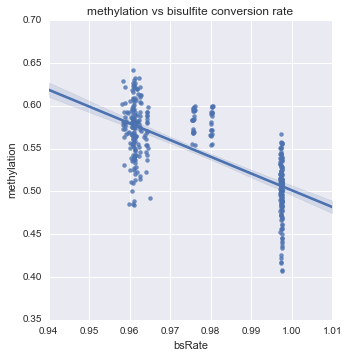

In [12]:
merged = pd.merge(combined2, bs, how='inner')
merged = merged.reset_index(drop=True)
merged = merged.rename(columns = {'totCpG':'Unique_CpGs'})
# Remove all data points with less than 100k in totcpg 
merged = merged[merged['total_reads'] > 100000]
scattermatrix1 = merged.drop(['filename', 'total_reads', 'type', 'protocol', 'avgReadCpGs_median'], axis=1)
sns.lmplot(x="bsRate", y="methylation",  data=scattermatrix1)
plt.title("methylation vs bisulfite conversion rate")

In [13]:
scattermatrix7 = merged.drop(['filename', 'bio', 'avgReadCpGs_median'], axis=1)
y = scattermatrix7.methylation # dependent variable
print(y.shape)
X = scattermatrix7.drop(['methylation', 'total_reads', 'protocol'], axis=1)
print(X.shape)

categorical_variables = ['type']
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    
import statsmodels.api as sm
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool1', predict methylation")
print("Variables: Number of unique CpGs per cell, mean Average Read CpG per cell, BS rate, Cll or Normal B")
est.summary()

(358,)
(358, 4)
Regression results for CLL 'RRBS_trito_pool1', predict methylation
Variables: Number of unique CpGs per cell, mean Average Read CpG per cell, BS rate, Cll or Normal B


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            methylation   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     244.9
Date:                Fri, 08 Jul 2016   Prob (F-statistic):          1.98e-100
Time:                        20:43:38   Log-Likelihood:                 819.51
No. Observations:                 358   AIC:                            -1629.
Df Residuals:                     353   BIC:                            -1610.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                1.7395      0.066     26.386      0.000         1.610     1.869
avgReadCpGs_mean    -0.0866      0.010     -8.690      0.000        -0.106    -0.067
Unique_CpGs       8.995e-08   5.46e-09     16.463      0.000      7.92e-08  1.01e-07
bsRate              -1.6804      0.084    -20.119      0.000        -1.845    -1.516
type_CLL             0.8689      0.033     26.612      0.000         0.805     0.933
type_normal          0.8707      0.033     26.105      0.000         0.805     0.936
==============================================================================
Omnibus:                       10.428   Durbin-Watson:                   1.521
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.343
Skew:                          -0.266   Prob(JB):                      0.00127
Kurtosis:                       3.782   Cond. No.                     6.18e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.03e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [14]:
tritopool = merged[merged["protocol"] == 'trito_pool_1']
tritopool = tritopool.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
tritopoolA = tritopool.set_index("filename")
from itertools import combinations
cc = list(combinations(tritopool.filename,2))
out = pd.DataFrame([tritopoolA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(tritopool.methylation, tritopool.methylation)), tritopool.filename, tritopool.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs = pd.merge(out, methylation_differences, how='inner')
print(pairs.shape)
pairs = pairs.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs.methylation_difference # dependent variable
X = pairs.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool1', predict \delta methylation")
est.summary()

(210, 7)
(210,)
(210, 3)
Regression results for CLL 'RRBS_trito_pool1', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.044
Model:                                OLS   Adj. R-squared:                  0.030
Method:                     Least Squares   F-statistic:                     3.170
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):             0.0253
Time:                            20:43:38   Log-Likelihood:                 633.96
No. Observations:                     210   AIC:                            -1260.
Df Residuals:                         206   BIC:                            -1247.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -30.8411     11.450     -2.693      0.008       -53.416    -8.266
avgReadCpGs_mean     0.0035      0.016      0.228      0.820        -0.027     0.034
Unique_CpGs_mean -3.033e-08   1.08e-08     -2.809      0.005     -5.16e-08 -9.04e-09
bsRate_mean         31.4891     11.670      2.698      0.008         8.482    54.496
==============================================================================
Omnibus:                       23.361   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.969
Skew:                           0.249   Prob(JB):                       0.0113
Kurtosis:                       2.118   Cond. No.                     1.72e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


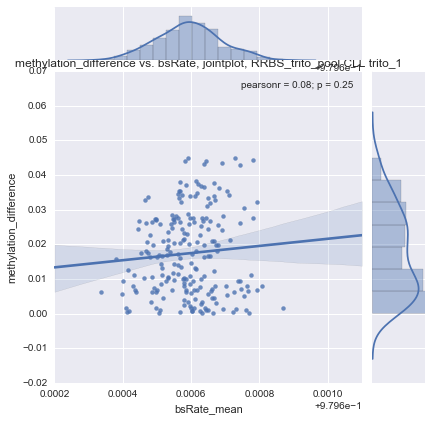

In [15]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, RRBS_trito_pool CLL trito_1")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


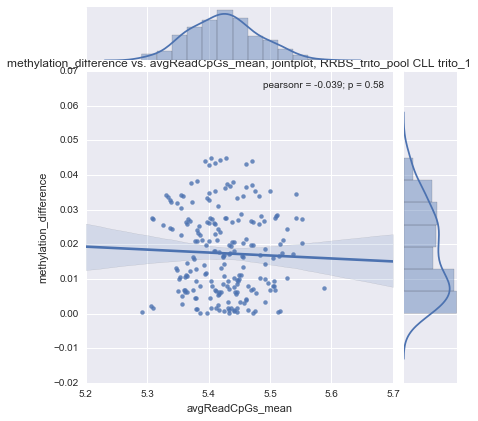

In [16]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, RRBS_trito_pool CLL trito_1")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


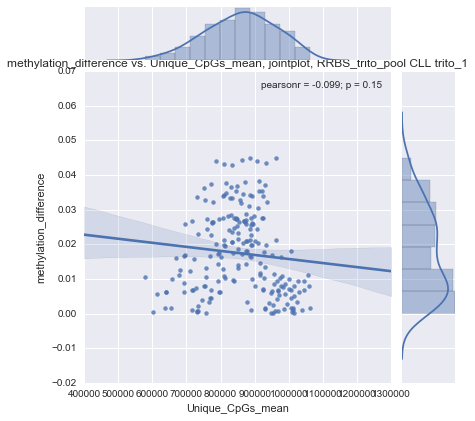

In [17]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, RRBS_trito_pool CLL trito_1")

In [18]:
tritopool2 = merged[merged["protocol"] == 'trito_pool_2']
tritopool2 = tritopool2.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
tritopool2A = tritopool2.set_index("filename")
from itertools import combinations
cc = list(combinations(tritopool2.filename,2))
out = pd.DataFrame([tritopool2A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(tritopool2.methylation, tritopool2.methylation)), tritopool2.filename, tritopool2.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs1a = pd.merge(out, methylation_differences, how='inner')
print(pairs1a.shape)
pairs1a = pairs1a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs1a.methylation_difference # dependent variable
X = pairs1a.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool_2', predict \delta methylation")
est.summary()

(253, 7)
(253,)
(253, 3)
Regression results for CLL 'RRBS_trito_pool_2', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.075
Model:                                OLS   Adj. R-squared:                  0.064
Method:                     Least Squares   F-statistic:                     6.704
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           0.000228
Time:                            20:43:42   Log-Likelihood:                 774.10
No. Observations:                     253   AIC:                            -1540.
Df Residuals:                         249   BIC:                            -1526.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                4.0515      7.014      0.578      0.564        -9.762    17.865
avgReadCpGs_mean     0.0448      0.014      3.188      0.002         0.017     0.073
Unique_CpGs_mean -2.134e-08   5.83e-09     -3.662      0.000     -3.28e-08 -9.86e-09
bsRate_mean         -4.3667      7.221     -0.605      0.546       -18.590     9.856
==============================================================================
Omnibus:                       11.026   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.386
Skew:                           0.441   Prob(JB):                      0.00556
Kurtosis:                       2.544   Cond. No.                     1.24e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


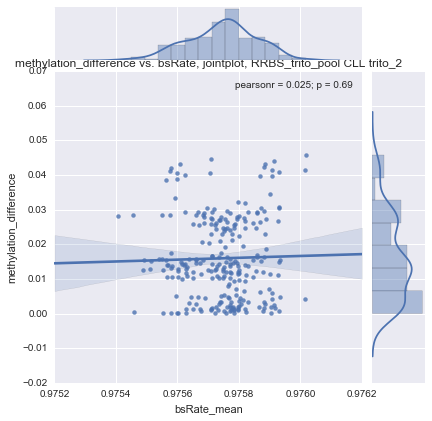

In [19]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs1a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, RRBS_trito_pool CLL trito_2")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


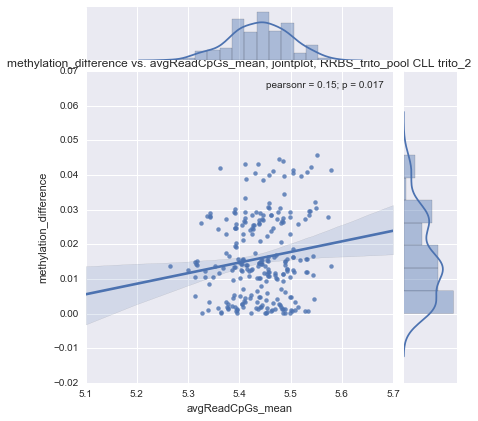

In [20]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs1a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, RRBS_trito_pool CLL trito_2")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


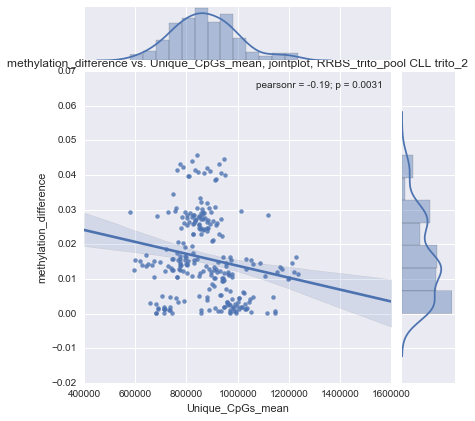

In [21]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs1a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, RRBS_trito_pool CLL trito_2")

In [22]:
cw154 = merged[merged["protocol"] == 'cw154_Tris_protease']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.methylation, cw154.methylation)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2 = pd.merge(out, methylation_differences, how='inner')
pairs2 = pairs2.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2.methylation_difference # dependent variable
X = pairs2.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'cw154_Tris_protease', predict \delta methylation")
est.summary()

Regression results for CLL 'cw154_Tris_protease', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.150
Model:                                OLS   Adj. R-squared:                  0.138
Method:                     Least Squares   F-statistic:                     12.12
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           2.45e-07
Time:                            20:43:46   Log-Likelihood:                 466.45
No. Observations:                     210   AIC:                            -924.9
Df Residuals:                         206   BIC:                            -911.5
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               27.9501     11.885      2.352      0.020         4.518    51.382
avgReadCpGs_mean     0.0319      0.024      1.330      0.185        -0.015     0.079
Unique_CpGs_mean -6.978e-08    1.7e-08     -4.114      0.000     -1.03e-07 -3.63e-08
bsRate_mean        -29.1983     12.440     -2.347      0.020       -53.723    -4.673
==============================================================================
Omnibus:                        9.460   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.865
Skew:                           0.531   Prob(JB):                      0.00721
Kurtosis:                       2.998   Cond. No.                     3.92e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


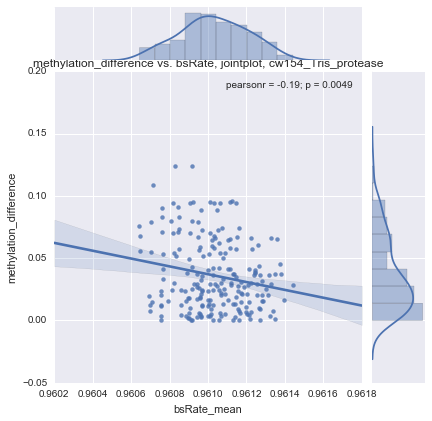

In [23]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs2, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, cw154_Tris_protease")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


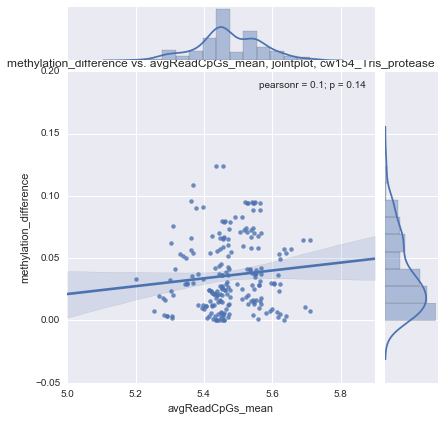

In [24]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs2, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


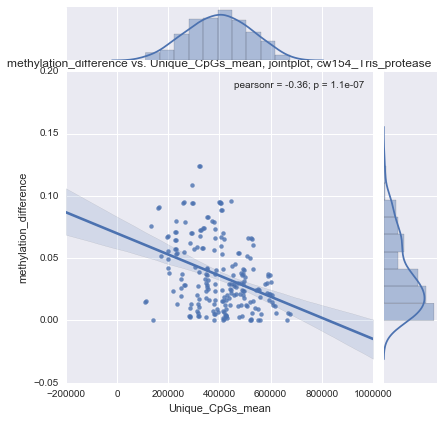

In [25]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs2, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease")

In [26]:
cw154 = merged[merged["protocol"] == 'cw154_Tris_protease_GR']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.methylation, cw154.methylation)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2a = pd.merge(out, methylation_differences, how='inner')
pairs2a = pairs2a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2a.methylation_difference # dependent variable
X = pairs2a.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_cw154_Tris_protease_GR', predict \delta methylation")
est.summary()

Regression results for CLL 'RRBS_cw154_Tris_protease_GR', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.119
Model:                                OLS   Adj. R-squared:                  0.106
Method:                     Least Squares   F-statistic:                     9.243
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           9.19e-06
Time:                            20:43:50   Log-Likelihood:                 498.15
No. Observations:                     210   AIC:                            -988.3
Df Residuals:                         206   BIC:                            -974.9
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -36.4798     10.516     -3.469      0.001       -57.212   -15.747
avgReadCpGs_mean    -0.0011      0.017     -0.066      0.947        -0.034     0.032
Unique_CpGs_mean -4.471e-08    1.2e-08     -3.732      0.000     -6.83e-08 -2.11e-08
bsRate_mean         38.0273     10.995      3.459      0.001        16.351    59.703
==============================================================================
Omnibus:                       11.183   Durbin-Watson:                   2.372
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                5.059
Skew:                          -0.097   Prob(JB):                       0.0797
Kurtosis:                       2.265   Cond. No.                     5.05e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


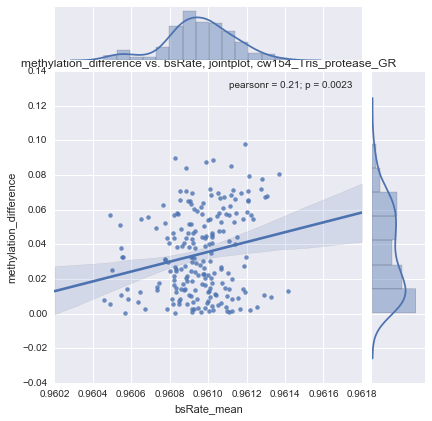

In [27]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs2a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


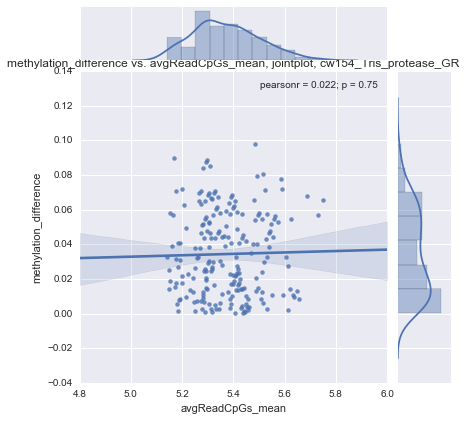

In [28]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs2a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


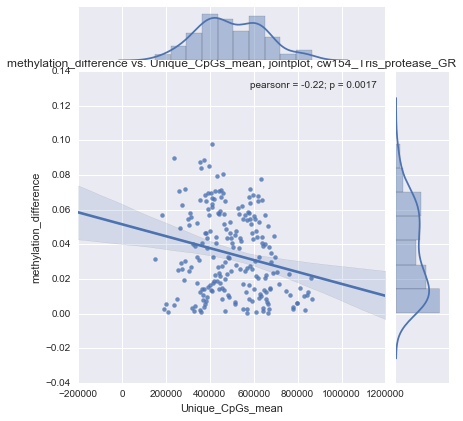

In [29]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs2a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease_GR")

In [30]:
# cw154_CutSmart_proteinase_K
cw154 = merged[merged["protocol"] == 'cw154_CutSmart_proteinase_K']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.methylation, cw154.methylation)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2b = pd.merge(out, methylation_differences, how='inner')
pairs2b = pairs2b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2b.methylation_difference # dependent variable
X = pairs2b.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'cw154_CutSmart_proteinase_K', predict \delta methylation")
est.summary()

Regression results for CLL 'cw154_CutSmart_proteinase_K', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.425
Model:                                OLS   Adj. R-squared:                  0.416
Method:                     Least Squares   F-statistic:                     50.68
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           1.41e-24
Time:                            20:43:54   Log-Likelihood:                 555.04
No. Observations:                     210   AIC:                            -1102.
Df Residuals:                         206   BIC:                            -1089.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -58.0948      6.405     -9.071      0.000       -70.722   -45.468
avgReadCpGs_mean     0.0131      0.027      0.487      0.627        -0.040     0.066
Unique_CpGs_mean -6.274e-08   1.02e-08     -6.165      0.000     -8.28e-08 -4.27e-08
bsRate_mean         60.2492      6.642      9.071      0.000        47.154    73.344
==============================================================================
Omnibus:                        4.147   Durbin-Watson:                   1.431
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                2.808
Skew:                           0.102   Prob(JB):                        0.246
Kurtosis:                       2.471   Cond. No.                     5.01e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


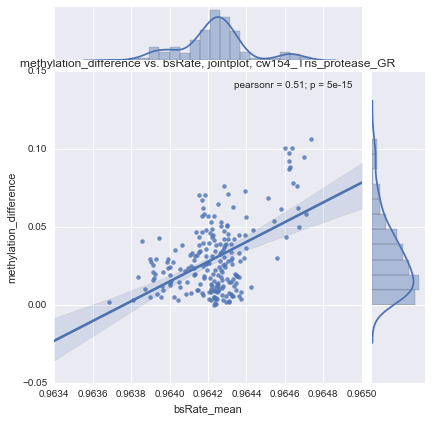

In [31]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs2b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


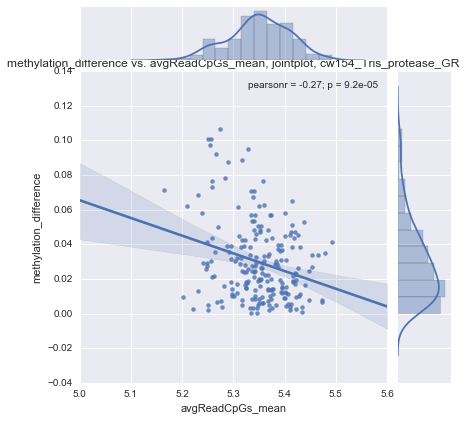

In [32]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs2b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


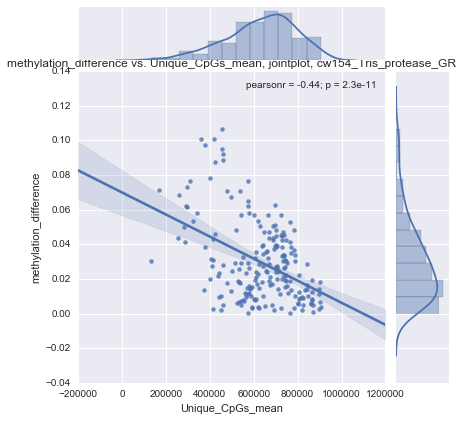

In [33]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs2b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease_GR")

In [34]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell1_22_']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation, pcell.methylation)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3 = pd.merge(out, methylation_differences, how='inner')
pairs3 = pairs3.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3.methylation_difference # dependent variable
X = pairs3.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell1_22', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.129
Model:                                OLS   Adj. R-squared:                  0.111
Method:                     Least Squares   F-statistic:                     7.338
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           0.000127
Time:                            20:43:57   Log-Likelihood:                 339.37
No. Observations:                     153   AIC:                            -670.7
Df Residuals:                         149   BIC:                            -658.6
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -63.7209     37.622     -1.694      0.092      -138.062    10.620
avgReadCpGs_mean     0.1418      0.036      3.979      0.000         0.071     0.212
Unique_CpGs_mean -2.129e-09   2.82e-08     -0.076      0.940     -5.78e-08  5.36e-08
bsRate_mean         63.1719     37.712      1.675      0.096       -11.348   137.691
==============================================================================
Omnibus:                       12.249   Durbin-Watson:                   1.114
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.823
Skew:                           0.686   Prob(JB):                      0.00164
Kurtosis:                       3.356   Cond. No.                     9.28e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.28e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


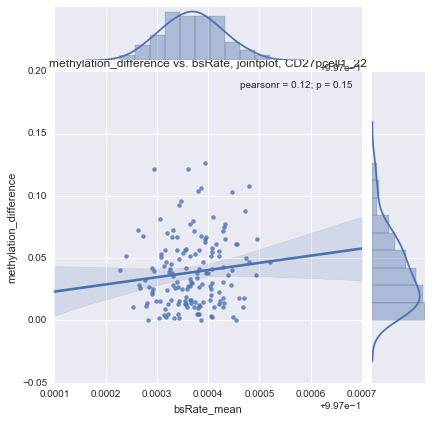

In [35]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, CD27pcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


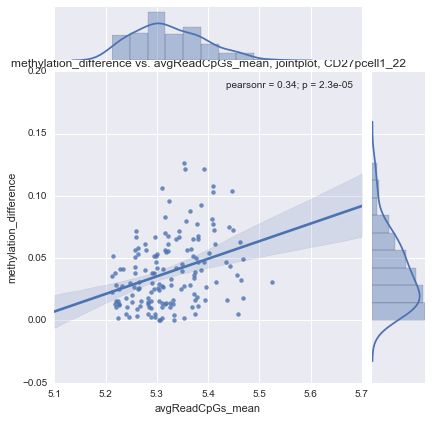

In [36]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, CD27pcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


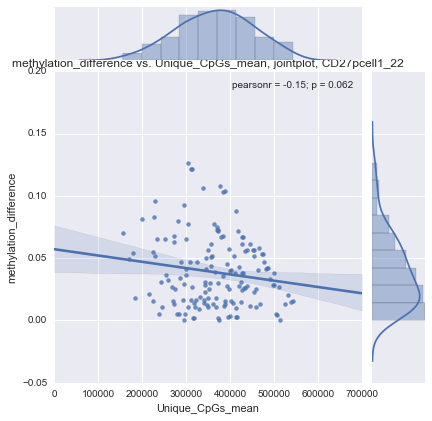

In [37]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, CD27pcell1_22")

In [38]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell23_44']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation, pcell.methylation)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3a = pd.merge(out, methylation_differences, how='inner')
pairs3a = pairs3a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3a.methylation_difference # dependent variable
X = pairs3a.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell22_34', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell22_34', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.109
Model:                                OLS   Adj. R-squared:                  0.097
Method:                     Least Squares   F-statistic:                     9.256
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           8.44e-06
Time:                            20:44:00   Log-Likelihood:                 512.40
No. Observations:                     231   AIC:                            -1017.
Df Residuals:                         227   BIC:                            -1003.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -57.8656     44.074     -1.313      0.191      -144.712    28.981
avgReadCpGs_mean     0.1037      0.022      4.610      0.000         0.059     0.148
Unique_CpGs_mean  3.052e-08   2.68e-08      1.140      0.255     -2.22e-08  8.33e-08
bsRate_mean         57.4776     44.157      1.302      0.194       -29.531   144.487
==============================================================================
Omnibus:                       13.529   Durbin-Watson:                   1.565
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.562
Skew:                           0.614   Prob(JB):                     0.000689
Kurtosis:                       3.083   Cond. No.                     1.28e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


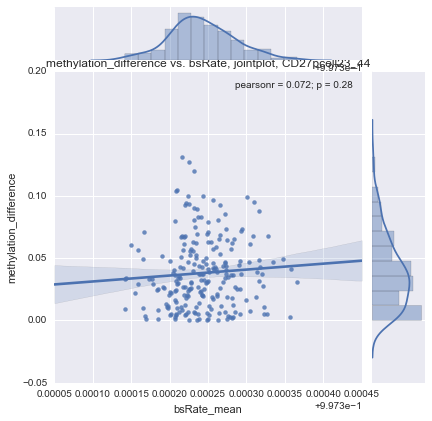

In [39]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, CD27pcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


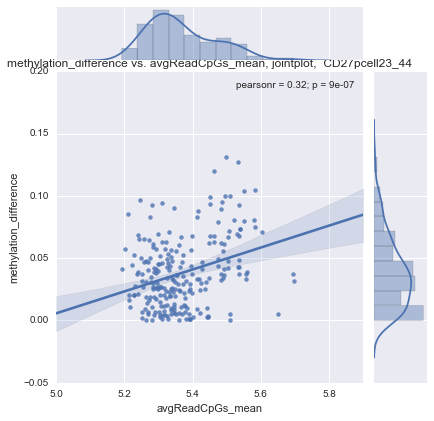

In [40]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot,  CD27pcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


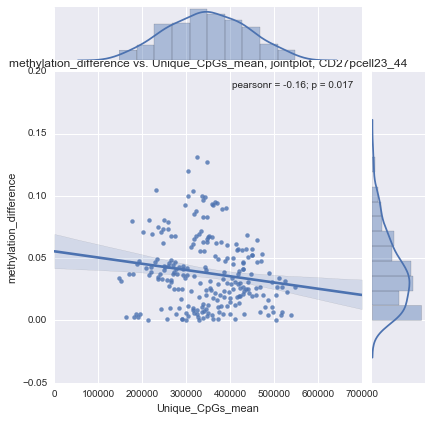

In [41]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, CD27pcell23_44")

In [42]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell45_66']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation, pcell.methylation)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3b = pd.merge(out, methylation_differences, how='inner')
pairs3b = pairs3b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3b.methylation_difference # dependent variable
X = pairs3b.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell45_66', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell45_66', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.416
Model:                                OLS   Adj. R-squared:                  0.362
Method:                     Least Squares   F-statistic:                     7.607
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           0.000563
Time:                            20:44:03   Log-Likelihood:                 84.899
No. Observations:                      36   AIC:                            -161.8
Df Residuals:                          32   BIC:                            -155.5
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              429.7823    173.141      2.482      0.018        77.105   782.459
avgReadCpGs_mean     0.0488      0.059      0.824      0.416        -0.072     0.169
Unique_CpGs_mean -1.835e-08   2.45e-08     -0.748      0.460     -6.83e-08  3.16e-08
bsRate_mean       -431.0635    173.329     -2.487      0.018      -784.123   -78.004
==============================================================================
Omnibus:                        4.608   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                3.191
Skew:                          -0.652   Prob(JB):                        0.203
Kurtosis:                       3.653   Cond. No.                     3.46e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


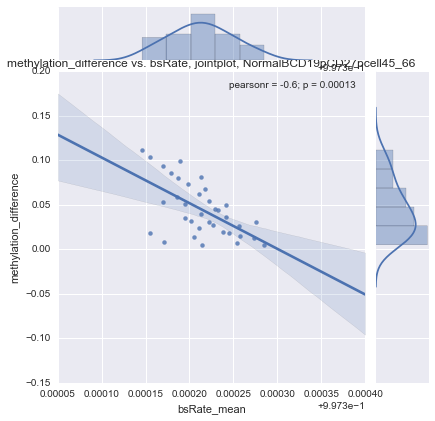

In [43]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


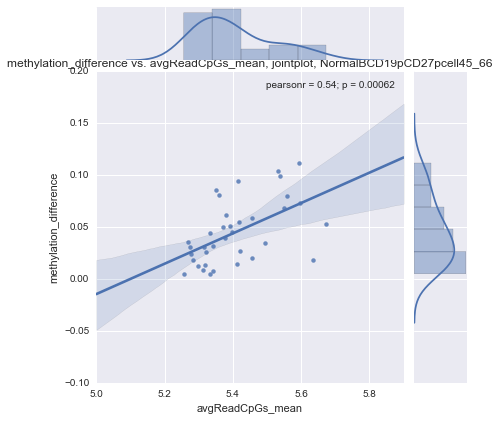

In [44]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27pcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


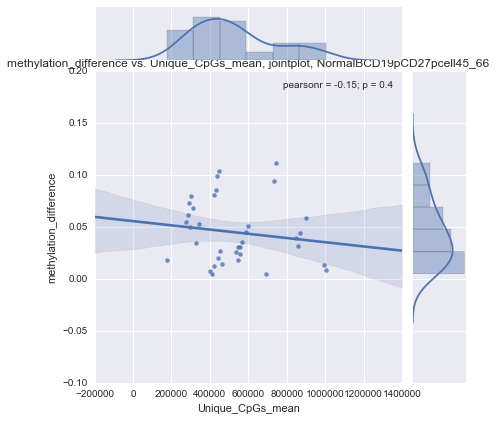

In [45]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27pcell45_66")

In [46]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell67_88']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation, pcell.methylation)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3c = pd.merge(out, methylation_differences, how='inner')
pairs3c = pairs3c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3c.methylation_difference # dependent variable
X = pairs3c.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell67_88', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell67_88', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.078
Model:                                OLS   Adj. R-squared:                  0.064
Method:                     Least Squares   F-statistic:                     5.780
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           0.000819
Time:                            20:44:06   Log-Likelihood:                 537.22
No. Observations:                     210   AIC:                            -1066.
Df Residuals:                         206   BIC:                            -1053.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               96.9221     28.233      3.433      0.001        41.260   152.584
avgReadCpGs_mean    -0.0722      0.030     -2.429      0.016        -0.131    -0.014
Unique_CpGs_mean -2.294e-08   1.66e-08     -1.384      0.168     -5.56e-08  9.74e-09
bsRate_mean        -96.7823     28.250     -3.426      0.001      -152.479   -41.086
==============================================================================
Omnibus:                       23.203   Durbin-Watson:                   1.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.306
Skew:                           0.845   Prob(JB):                     1.18e-06
Kurtosis:                       3.515   Cond. No.                     1.06e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


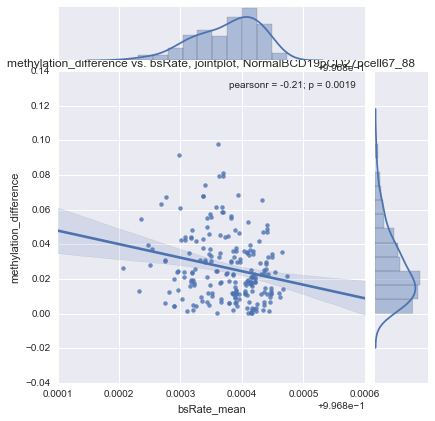

In [47]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


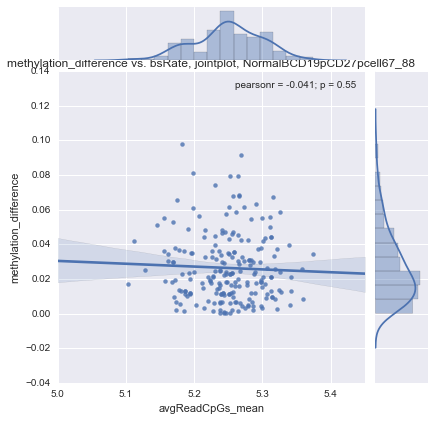

In [48]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


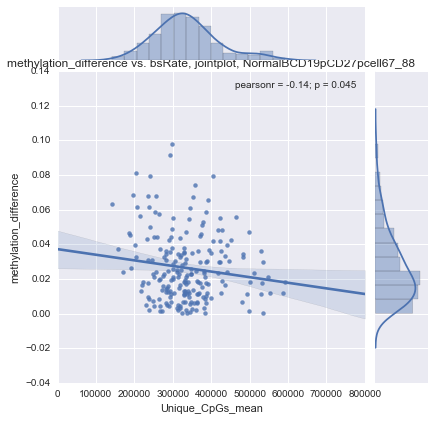

In [49]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

In [50]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell1_22_']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation, mcell.methylation)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4 = pd.merge(out, methylation_differences, how='inner')
pairs4 = pairs4.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4.methylation_difference # dependent variable
X = pairs4.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell1_22', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.408
Model:                                OLS   Adj. R-squared:                  0.396
Method:                     Least Squares   F-statistic:                     34.25
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           6.77e-17
Time:                            20:44:11   Log-Likelihood:                 349.66
No. Observations:                     153   AIC:                            -691.3
Df Residuals:                         149   BIC:                            -679.2
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             -142.3487     59.312     -2.400      0.018      -259.549   -25.148
avgReadCpGs_mean     0.2913      0.036      8.112      0.000         0.220     0.362
Unique_CpGs_mean  1.981e-07   3.35e-08      5.907      0.000      1.32e-07  2.64e-07
bsRate_mean        141.1063     59.534      2.370      0.019        23.466   258.747
==============================================================================
Omnibus:                        6.550   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                5.166
Skew:                           0.343   Prob(JB):                       0.0755
Kurtosis:                       2.418   Cond. No.                     1.65e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


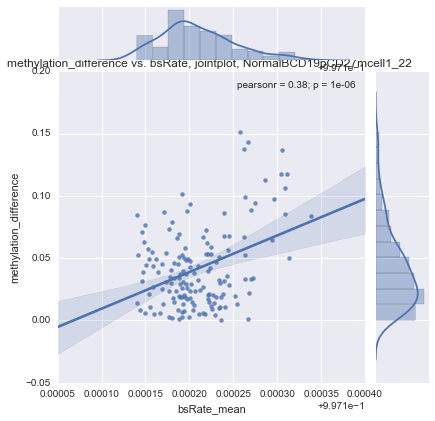

In [51]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell1_22 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


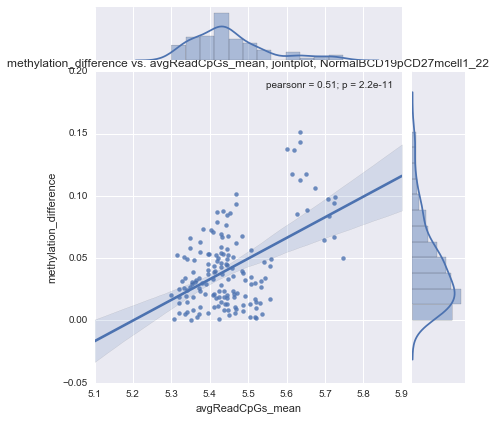

In [52]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


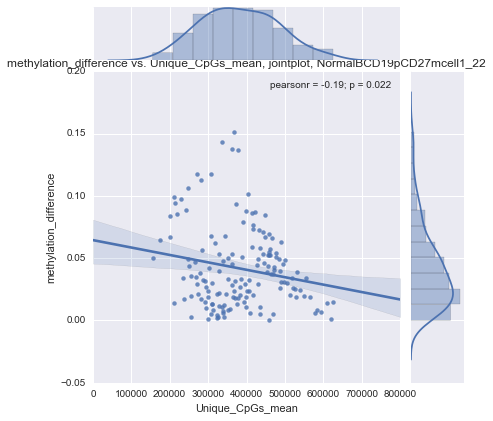

In [53]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell1_22")

In [54]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell23_44']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation, mcell.methylation)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4a = pd.merge(out, methylation_differences, how='inner')
pairs4a = pairs4a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4a.methylation_difference # dependent variable
X = pairs4a.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.079
Model:                                OLS   Adj. R-squared:                  0.063
Method:                     Least Squares   F-statistic:                     4.785
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):            0.00317
Time:                            20:44:14   Log-Likelihood:                 414.31
No. Observations:                     171   AIC:                            -820.6
Df Residuals:                         167   BIC:                            -808.0
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             -112.8148     63.734     -1.770      0.079      -238.643    13.013
avgReadCpGs_mean    -0.1556      0.046     -3.410      0.001        -0.246    -0.065
Unique_CpGs_mean -6.544e-08   3.01e-08     -2.176      0.031     -1.25e-07 -6.06e-09
bsRate_mean        113.9791     63.896      1.784      0.076       -12.168   240.127
==============================================================================
Omnibus:                       14.102   Durbin-Watson:                   1.193
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.473
Skew:                           0.733   Prob(JB):                     0.000437
Kurtosis:                       3.155   Cond. No.                     1.91e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


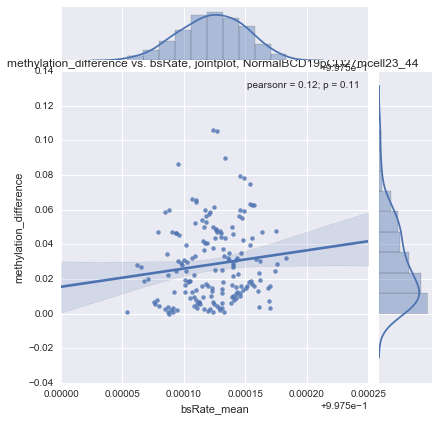

In [55]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell23_44 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


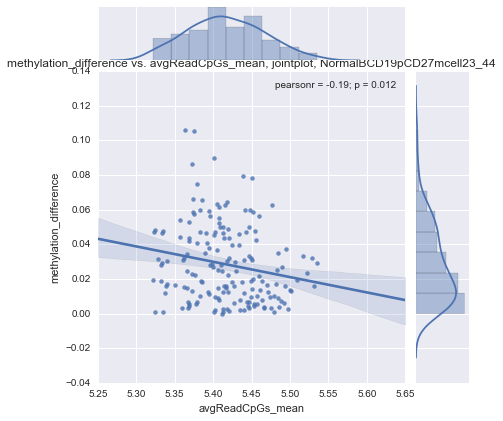

In [56]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


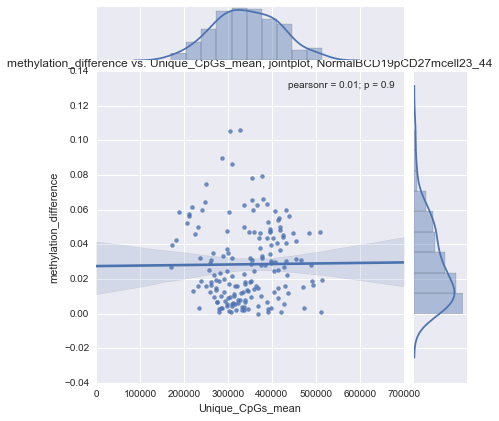

In [57]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell23_44")

In [58]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell45_66']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation, mcell.methylation)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4b = pd.merge(out, methylation_differences, how='inner')
pairs4b = pairs4b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4b.methylation_difference # dependent variable
X = pairs4b.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.338
Model:                                OLS   Adj. R-squared:                  0.323
Method:                     Least Squares   F-statistic:                     22.51
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           7.82e-12
Time:                            20:44:18   Log-Likelihood:                 309.74
No. Observations:                     136   AIC:                            -611.5
Df Residuals:                         132   BIC:                            -599.8
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              106.4405     64.814      1.642      0.103       -21.768   234.649
avgReadCpGs_mean     0.3095      0.039      7.996      0.000         0.233     0.386
Unique_CpGs_mean  2.243e-07   4.14e-08      5.412      0.000      1.42e-07  3.06e-07
bsRate_mean       -108.4172     64.978     -1.669      0.098      -236.949    20.115
==============================================================================
Omnibus:                        2.733   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                2.378
Skew:                           0.220   Prob(JB):                        0.304
Kurtosis:                       2.525   Cond. No.                     1.55e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


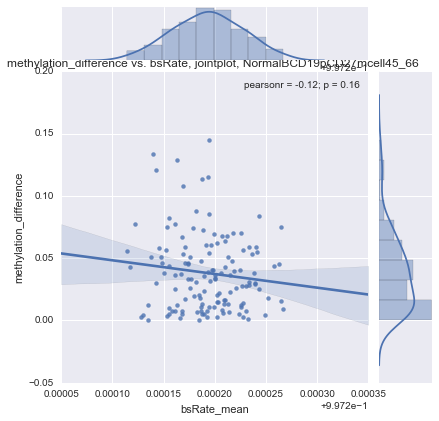

In [59]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell45_66 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


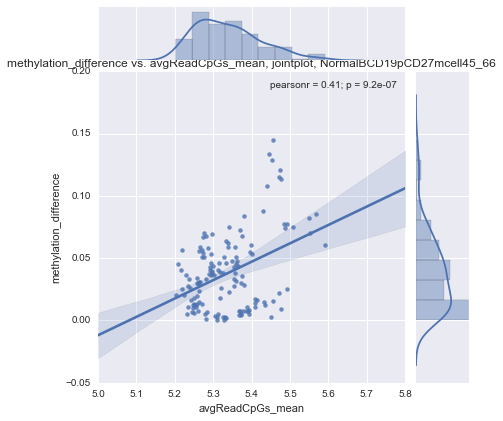

In [60]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


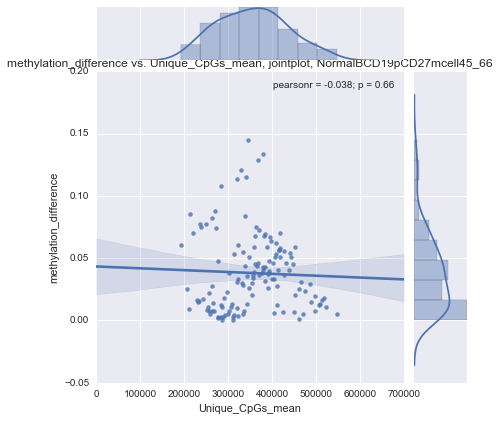

In [61]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell45_66")

In [62]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell67_88']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation, mcell.methylation)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4c = pd.merge(out, methylation_differences, how='inner')
pairs4c = pairs4c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4c.methylation_difference # dependent variable
X = pairs4c.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.112
Model:                                OLS   Adj. R-squared:                  0.099
Method:                     Least Squares   F-statistic:                     8.648
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           1.97e-05
Time:                            20:44:22   Log-Likelihood:                 456.44
No. Observations:                     210   AIC:                            -904.9
Df Residuals:                         206   BIC:                            -891.5
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -21.2954     64.755     -0.329      0.743      -148.962   106.371
avgReadCpGs_mean     0.1365      0.030      4.535      0.000         0.077     0.196
Unique_CpGs_mean  5.578e-08   2.87e-08      1.945      0.053     -7.54e-10  1.12e-07
bsRate_mean         20.6162     64.928      0.318      0.751      -107.392   148.625
==============================================================================
Omnibus:                        6.333   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.534
Skew:                           0.424   Prob(JB):                       0.0381
Kurtosis:                       2.830   Cond. No.                     2.04e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


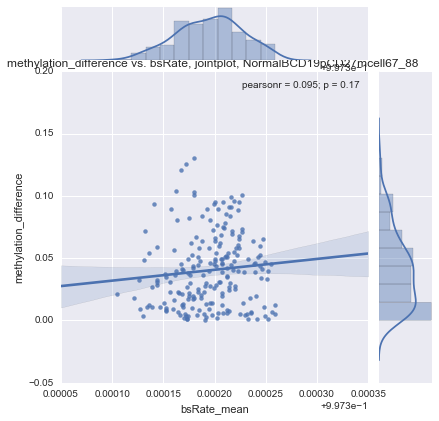

In [63]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell67_88 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


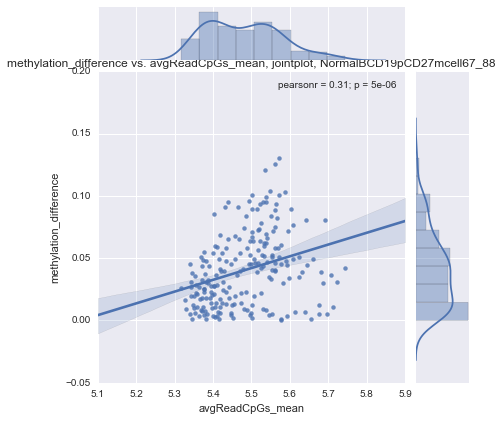

In [64]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4c, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


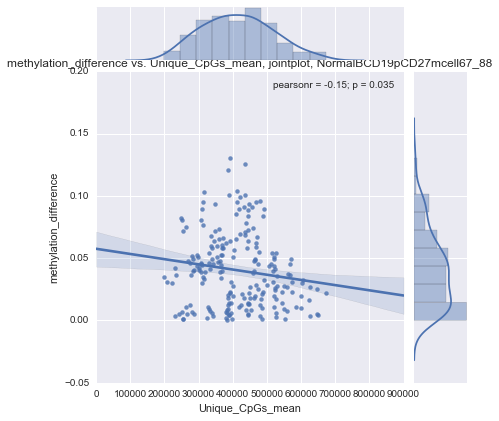

In [65]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4c, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell67_88")

In [66]:
normb = merged[merged["protocol"] == 'normal_B_cell_A1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5 = pd.merge(out, methylation_differences, how='inner')
pairs5 = pairs5.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5.methylation_difference # dependent variable
X = pairs5.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_A1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_A1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.046
Model:                                OLS   Adj. R-squared:                  0.031
Method:                     Least Squares   F-statistic:                     3.004
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):             0.0317
Time:                            20:44:26   Log-Likelihood:                 487.80
No. Observations:                     190   AIC:                            -967.6
Df Residuals:                         186   BIC:                            -954.6
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                9.4983      4.999      1.900      0.059        -0.364    19.360
avgReadCpGs_mean     0.0301      0.027      1.134      0.258        -0.022     0.082
Unique_CpGs_mean -8.307e-08   3.88e-08     -2.140      0.034      -1.6e-07 -6.51e-09
bsRate_mean        -10.0300      5.228     -1.918      0.057       -20.345     0.285
==============================================================================
Omnibus:                       27.556   Durbin-Watson:                   0.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.539
Skew:                           0.992   Prob(JB):                     3.16e-08
Kurtosis:                       3.651   Cond. No.                     1.17e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


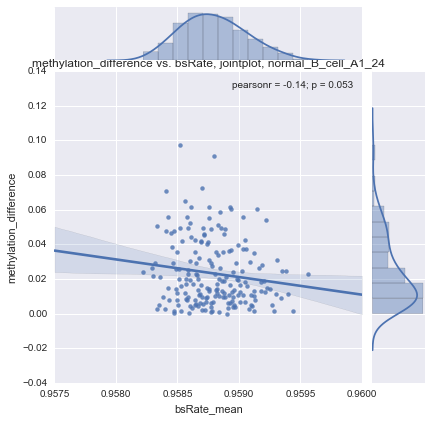

In [67]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_A1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


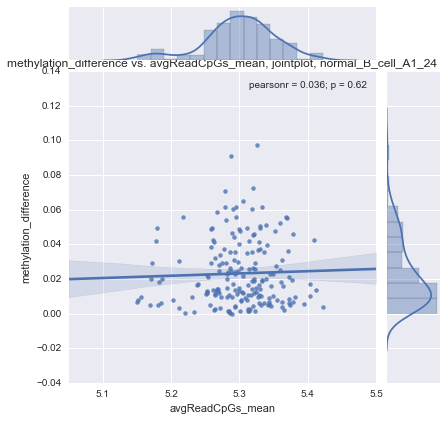

In [68]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_A1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


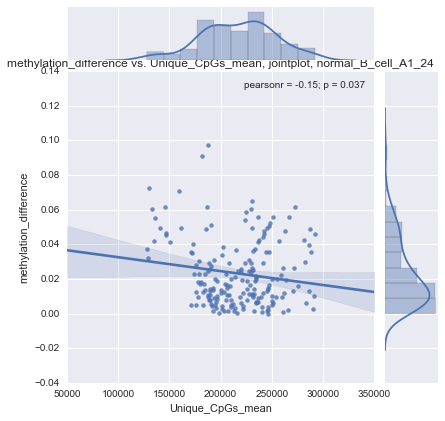

In [69]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_A1_24")

In [70]:
normb = merged[merged["protocol"] == 'normal_B_cell_B1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5a = pd.merge(out, methylation_differences, how='inner')
pairs5a = pairs5a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5a.methylation_difference # dependent variable
X = pairs5a.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_B1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_B1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.008
Model:                                OLS   Adj. R-squared:                 -0.008
Method:                     Least Squares   F-statistic:                    0.4706
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):              0.703
Time:                            20:44:30   Log-Likelihood:                 409.96
No. Observations:                     190   AIC:                            -811.9
Df Residuals:                         186   BIC:                            -798.9
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -15.2844     17.941     -0.852      0.395       -50.678    20.109
avgReadCpGs_mean    -0.0252      0.033     -0.757      0.450        -0.091     0.040
Unique_CpGs_mean   8.11e-09   1.88e-08      0.432      0.666     -2.89e-08  4.52e-08
bsRate_mean         16.0835     18.786      0.856      0.393       -20.978    53.145
==============================================================================
Omnibus:                       11.277   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.689
Skew:                           0.574   Prob(JB):                      0.00290
Kurtosis:                       2.602   Cond. No.                     5.83e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


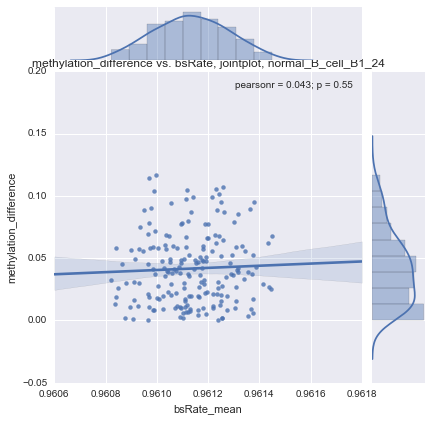

In [71]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_B1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


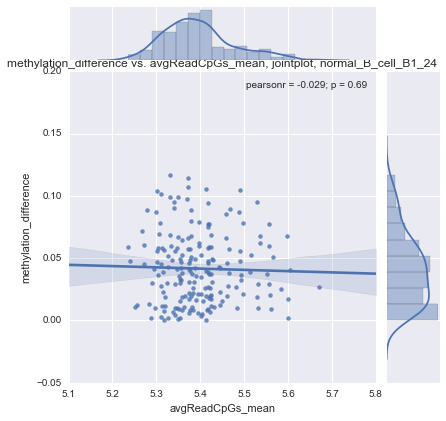

In [72]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_B1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


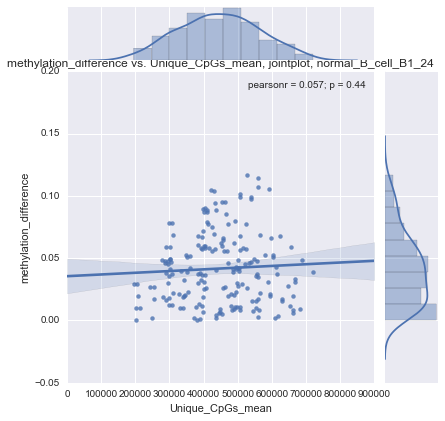

In [73]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_B1_24")

In [74]:
normb = merged[merged["protocol"] == 'normal_B_cell_C1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5b = pd.merge(out, methylation_differences, how='inner')
pairs5b = pairs5b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5b.methylation_difference # dependent variable
X = pairs5b.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_C1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_C1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.057
Model:                                OLS   Adj. R-squared:                  0.044
Method:                     Least Squares   F-statistic:                     4.546
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):            0.00408
Time:                            20:44:33   Log-Likelihood:                 508.11
No. Observations:                     231   AIC:                            -1008.
Df Residuals:                         227   BIC:                            -994.5
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -25.3987     14.710     -1.727      0.086       -54.383     3.586
avgReadCpGs_mean    -0.1283      0.040     -3.191      0.002        -0.207    -0.049
Unique_CpGs_mean -1.109e-08   8.83e-09     -1.255      0.211     -2.85e-08  6.32e-09
bsRate_mean         27.1712     15.417      1.762      0.079        -3.208    57.551
==============================================================================
Omnibus:                       14.694   Durbin-Watson:                   1.220
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.012
Skew:                           0.625   Prob(JB):                     0.000333
Kurtosis:                       2.680   Cond. No.                     9.25e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


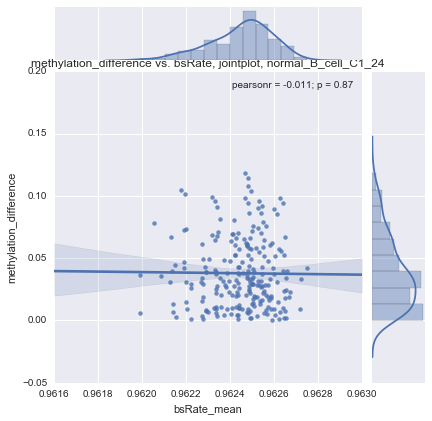

In [75]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_C1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


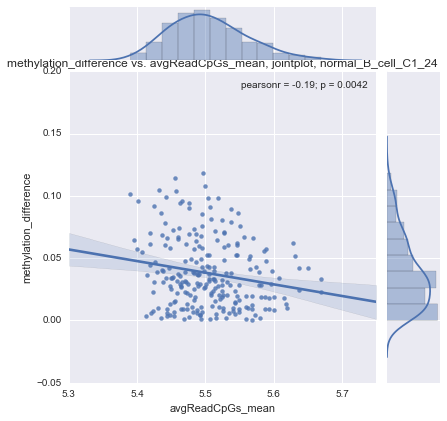

In [76]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_C1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


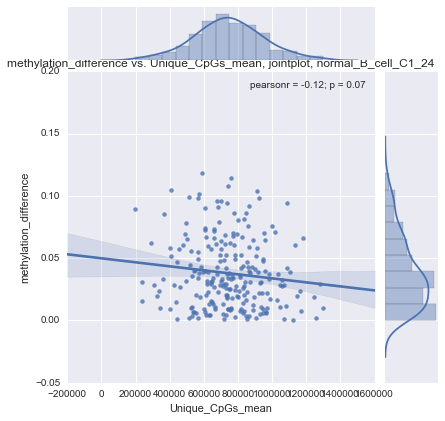

In [77]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_C1_24")

In [78]:
normb = merged[merged["protocol"] == 'normal_B_cell_D1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5c = pd.merge(out, methylation_differences, how='inner')
pairs5c = pairs5c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5c.methylation_difference # dependent variable
X = pairs5c.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_D1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_D1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.167
Model:                                OLS   Adj. R-squared:                  0.089
Method:                     Least Squares   F-statistic:                     2.135
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):              0.115
Time:                            20:44:37   Log-Likelihood:                 84.813
No. Observations:                      36   AIC:                            -161.6
Df Residuals:                          32   BIC:                            -155.3
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               11.2888     27.741      0.407      0.687       -45.218    67.796
avgReadCpGs_mean    -0.1331      0.060     -2.230      0.033        -0.255    -0.012
Unique_CpGs_mean   2.69e-09   2.78e-08      0.097      0.924      -5.4e-08  5.94e-08
bsRate_mean        -10.9401     28.891     -0.379      0.707       -69.789    47.908
==============================================================================
Omnibus:                        0.468   Durbin-Watson:                   2.444
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.587
Skew:                           0.040   Prob(JB):                        0.746
Kurtosis:                       2.380   Cond. No.                     7.43e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


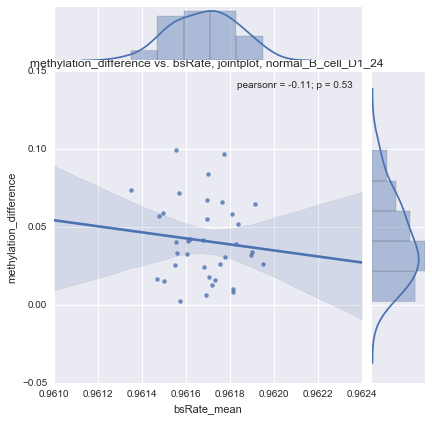

In [79]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_D1_24 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


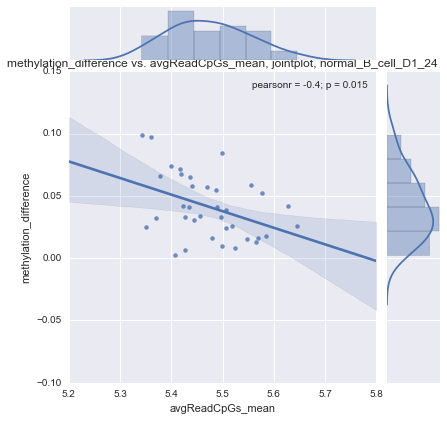

In [80]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5c, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_D1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


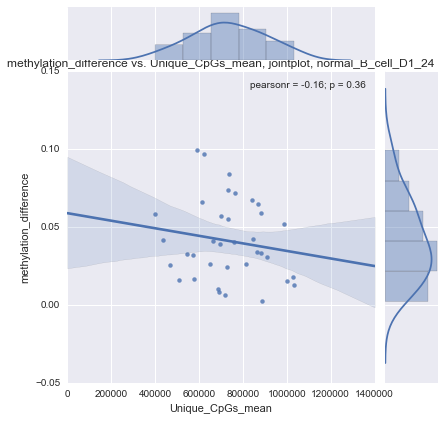

In [81]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5c, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_D1_24")

In [82]:
normb = merged[merged["protocol"] == 'normal_B_cell_G1_22']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5d = pd.merge(out, methylation_differences, how='inner')
pairs5d = pairs5d.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5d.methylation_difference # dependent variable
X = pairs5d.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_G1_22', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_G1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.072
Model:                                OLS   Adj. R-squared:                  0.056
Method:                     Least Squares   F-statistic:                     4.335
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):            0.00569
Time:                            20:44:41   Log-Likelihood:                 366.77
No. Observations:                     171   AIC:                            -725.5
Df Residuals:                         167   BIC:                            -713.0
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               31.3772     13.380      2.345      0.020         4.962    57.792
avgReadCpGs_mean     0.1735      0.049      3.530      0.001         0.076     0.270
Unique_CpGs_mean  2.446e-08   2.06e-08      1.186      0.237     -1.62e-08  6.52e-08
bsRate_mean        -33.6176     14.088     -2.386      0.018       -61.431    -5.804
==============================================================================
Omnibus:                       10.416   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.263
Skew:                           0.617   Prob(JB):                      0.00358
Kurtosis:                       2.761   Cond. No.                     5.53e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


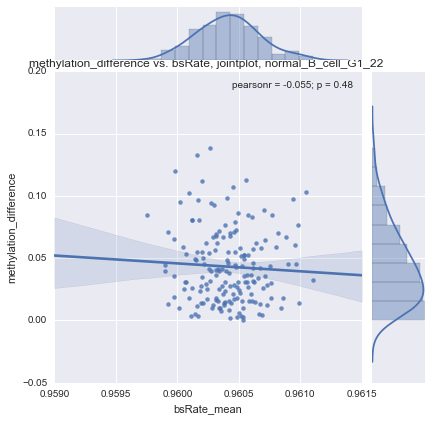

In [83]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5d, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_G1_22 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


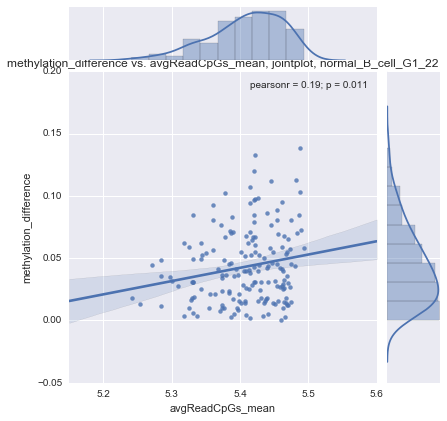

In [84]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5d, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_G1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


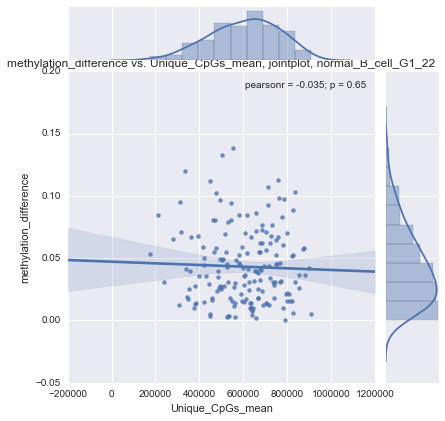

In [85]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5d, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_G1_22")

In [86]:
normb = merged[merged["protocol"] == 'normal_B_cell_H1_22']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5e = pd.merge(out, methylation_differences, how='inner')
pairs5e = pairs5e.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5e.methylation_difference # dependent variable
X = pairs5e.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_H1_22', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_H1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.070
Model:                                OLS   Adj. R-squared:                  0.046
Method:                     Least Squares   F-statistic:                     2.911
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):             0.0375
Time:                            20:44:45   Log-Likelihood:                 249.72
No. Observations:                     120   AIC:                            -491.4
Df Residuals:                         116   BIC:                            -480.3
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               16.7058     24.013      0.696      0.488       -30.856    64.267
avgReadCpGs_mean     0.1573      0.055      2.849      0.005         0.048     0.267
Unique_CpGs_mean -4.139e-08   3.27e-08     -1.266      0.208     -1.06e-07  2.33e-08
bsRate_mean        -18.1920     25.064     -0.726      0.469       -67.835    31.451
==============================================================================
Omnibus:                       12.702   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.712
Skew:                           0.817   Prob(JB):                      0.00105
Kurtosis:                       3.274   Cond. No.                     6.56e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


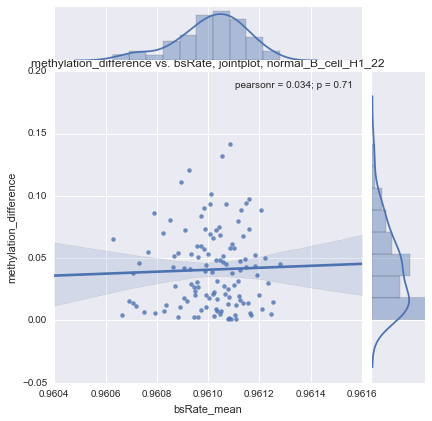

In [87]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5e, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_H1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


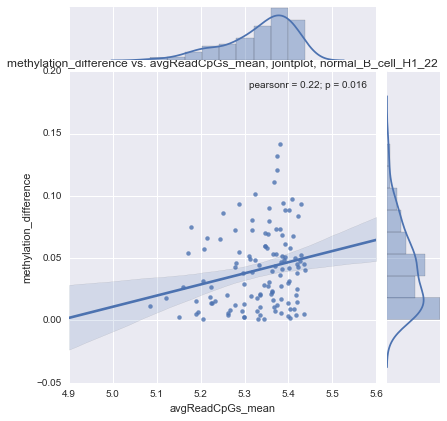

In [88]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5e, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_H1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


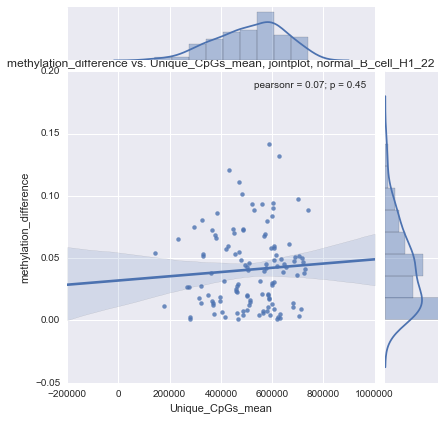

In [89]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5e, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_H1_22")

In [90]:
pairs['type'] = str('CLL')
pairs1a['type'] = str('CLL')
pairs2['type'] = str('CLL')
pairs2a['type'] = str('CLL')
pairs2b['type'] = str('CLL')
pairs3['type'] = str('CLL')
pairs3a['type'] = str('normal')
pairs3b['type'] = str('normal')
pairs3c['type'] = str('normal')
pairs4['type'] = str('normal')
pairs4a['type'] = str('normal')
pairs4b['type'] = str('normal')
pairs4c['type'] = str('normal')
pairs5['type'] = str('normal')
pairs5a['type'] = str('normal')
pairs5b['type'] = str('normal')
pairs5c['type'] = str('normal')
pairs5d['type'] = str('normal')
pairs5e['type'] = str('normal')

frames22 = [pairs, pairs2, pairs3, pairs4]
total_pairs = pd.concat(frames22)
y = total_pairs.methylation_difference # dependent variable
X = total_pairs.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)

categorical_variables = ['type']
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    
X = X.drop(['type_normal'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results, all batches 'Normal B' vs 'CLL' , predict \delta methylation")
est.summary()

Regression results, all batches 'Normal B' vs 'CLL' , predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.204
Model:                                OLS   Adj. R-squared:                  0.199
Method:                     Least Squares   F-statistic:                     46.16
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           1.51e-34
Time:                            20:44:50   Log-Likelihood:                 1661.7
No. Observations:                     726   AIC:                            -3313.
Df Residuals:                         721   BIC:                            -3290.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -0.5914      0.128     -4.603      0.000        -0.844    -0.339
avgReadCpGs_mean     0.0652      0.011      5.754      0.000         0.043     0.087
Unique_CpGs_mean -4.459e-08   4.01e-09    -11.113      0.000     -5.25e-08 -3.67e-08
bsRate_mean          0.2953      0.085      3.490      0.001         0.129     0.461
type_CLL             0.0042      0.003      1.392      0.164        -0.002     0.010
==============================================================================
Omnibus:                       78.490   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.120
Skew:                           0.801   Prob(JB):                     2.02e-24
Kurtosis:                       4.022   Cond. No.                     9.50e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


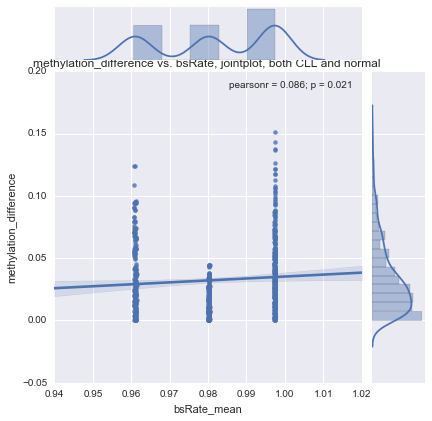

In [91]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=total_pairs, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, both CLL and normal ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


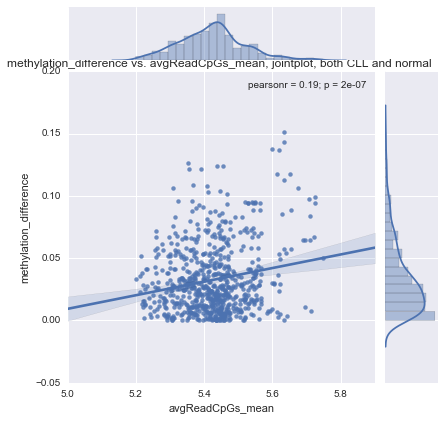

In [92]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=total_pairs, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, both CLL and normal ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


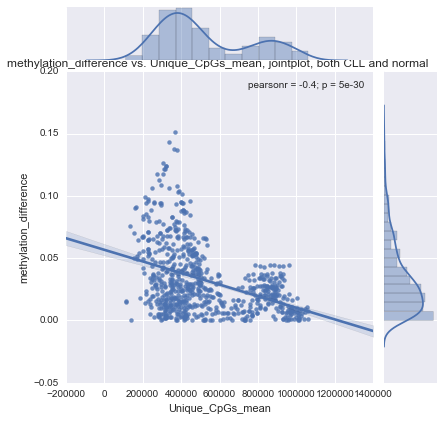

In [93]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=total_pairs, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, both CLL and normal ")

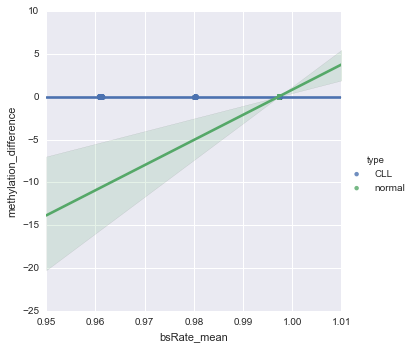

In [94]:
sns.lmplot(x="bsRate_mean", y="methylation_difference",  data=total_pairs, hue='type')

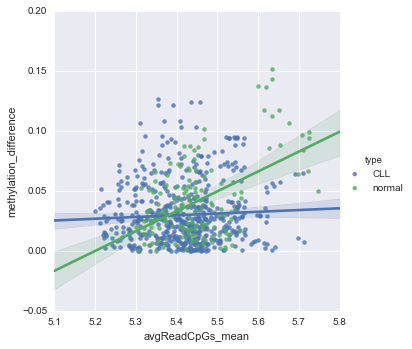

In [95]:
sns.lmplot(x="avgReadCpGs_mean", y="methylation_difference",  data=total_pairs, hue='type')

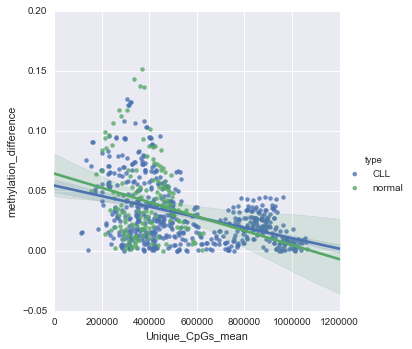

In [96]:
sns.lmplot(x="Unique_CpGs_mean", y="methylation_difference",  data=total_pairs, hue='type')

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


Random Forest model score is 0.912355181191


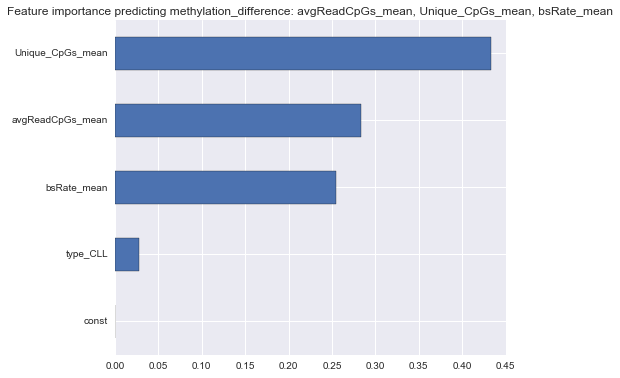

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model = RandomForestRegressor(n_estimators=10000, oob_score=True, random_state=36)
model.fit(X, y)
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6))
plt.title("Feature importance predicting methylation_difference: avgReadCpGs_mean, Unique_CpGs_mean, bsRate_mean")
print(str("Random Forest model score is ") + str(model.score(X,y)))